In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

sns.set_context("talk")

# Table

In [10]:
train = pd.read_csv('Data/3.5/train.csv')
test = pd.read_csv('Data/3.5/test.csv')
sub = pd.read_csv('Data/3.5/sample_submission.csv')

train.drop(columns=['Id'], inplace=True)
test.drop(columns=['Id'], inplace=True)

In [11]:
df = pd.concat([train, test])

# Missing Values

In [12]:
df.isnull().sum()

fixed acidity              0
volatile acidity           0
citric acid                0
residual sugar             0
chlorides                  0
free sulfur dioxide        0
total sulfur dioxide       0
density                    0
pH                         0
sulphates                  0
alcohol                    0
quality                 1372
dtype: int64

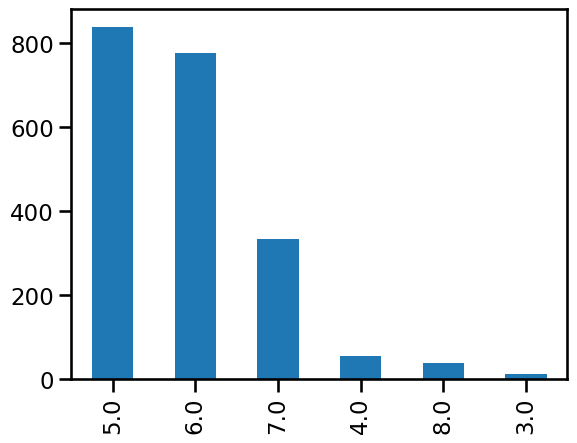

In [13]:
df.quality.value_counts().plot(kind='bar');

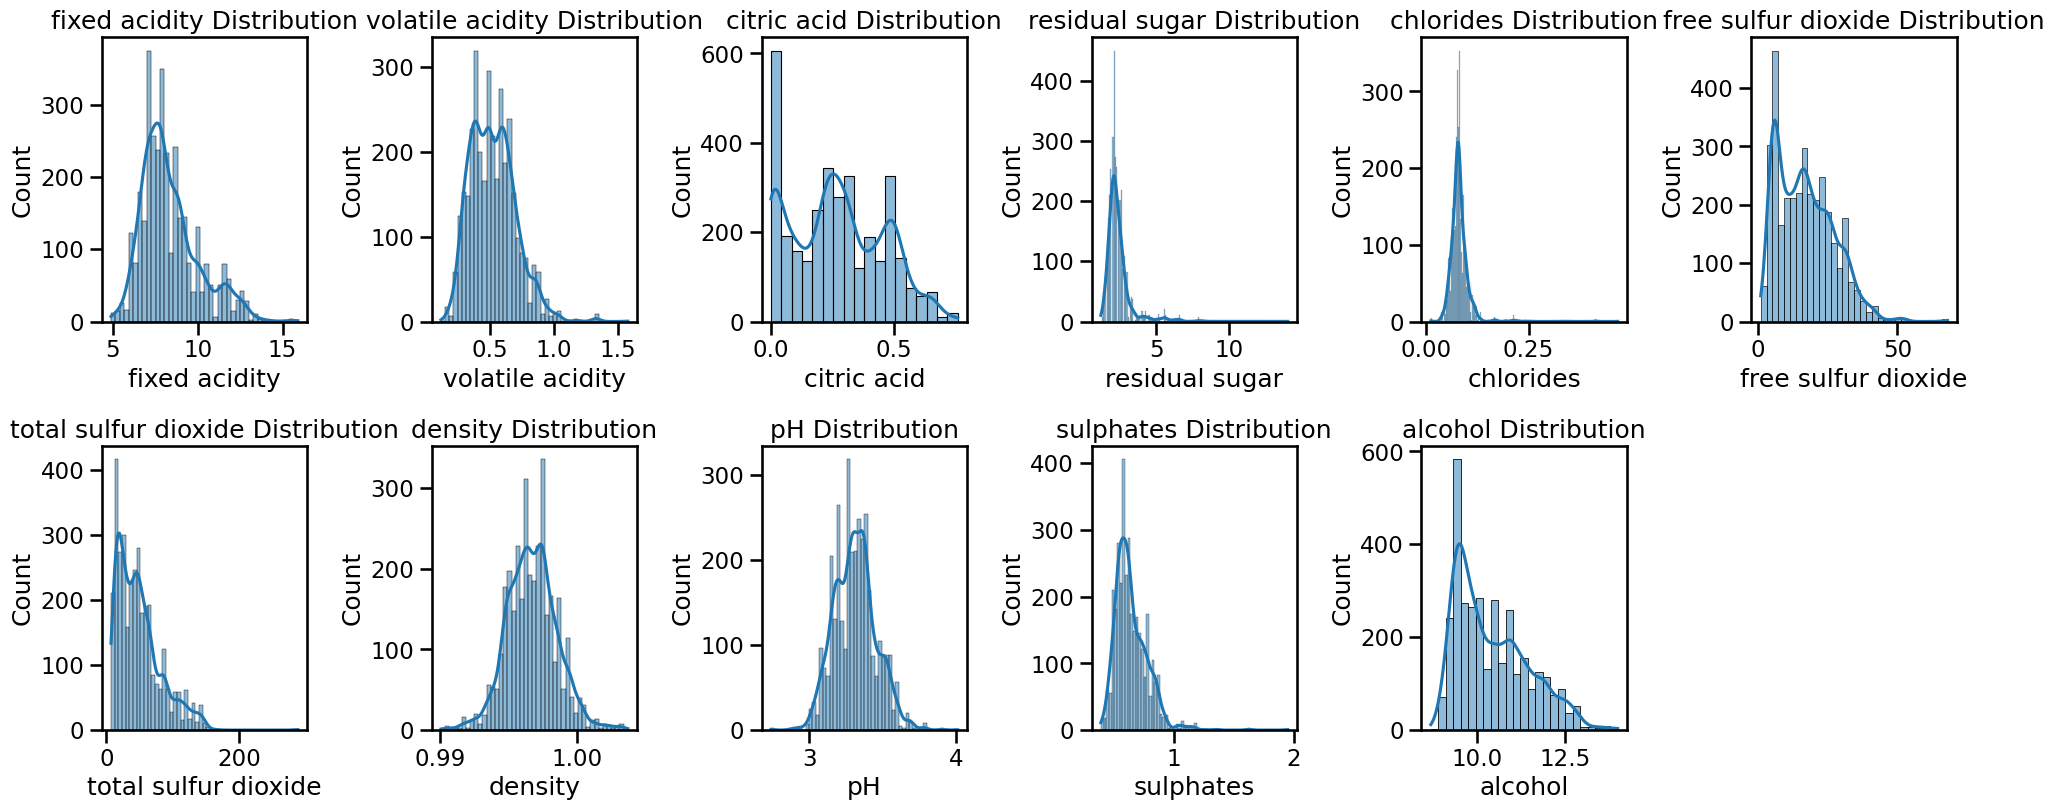

In [14]:
num_cols = test.columns.to_list()

def histograms_plot(dataframe, features, rows, cols): 
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        sns.histplot(x=dataframe[feature], fill=True, data=train, kde=True)
        ax.set_title(feature+" Distribution",color='black')
    fig.tight_layout()  
    plt.show()

histograms_plot(df,num_cols,5,6)

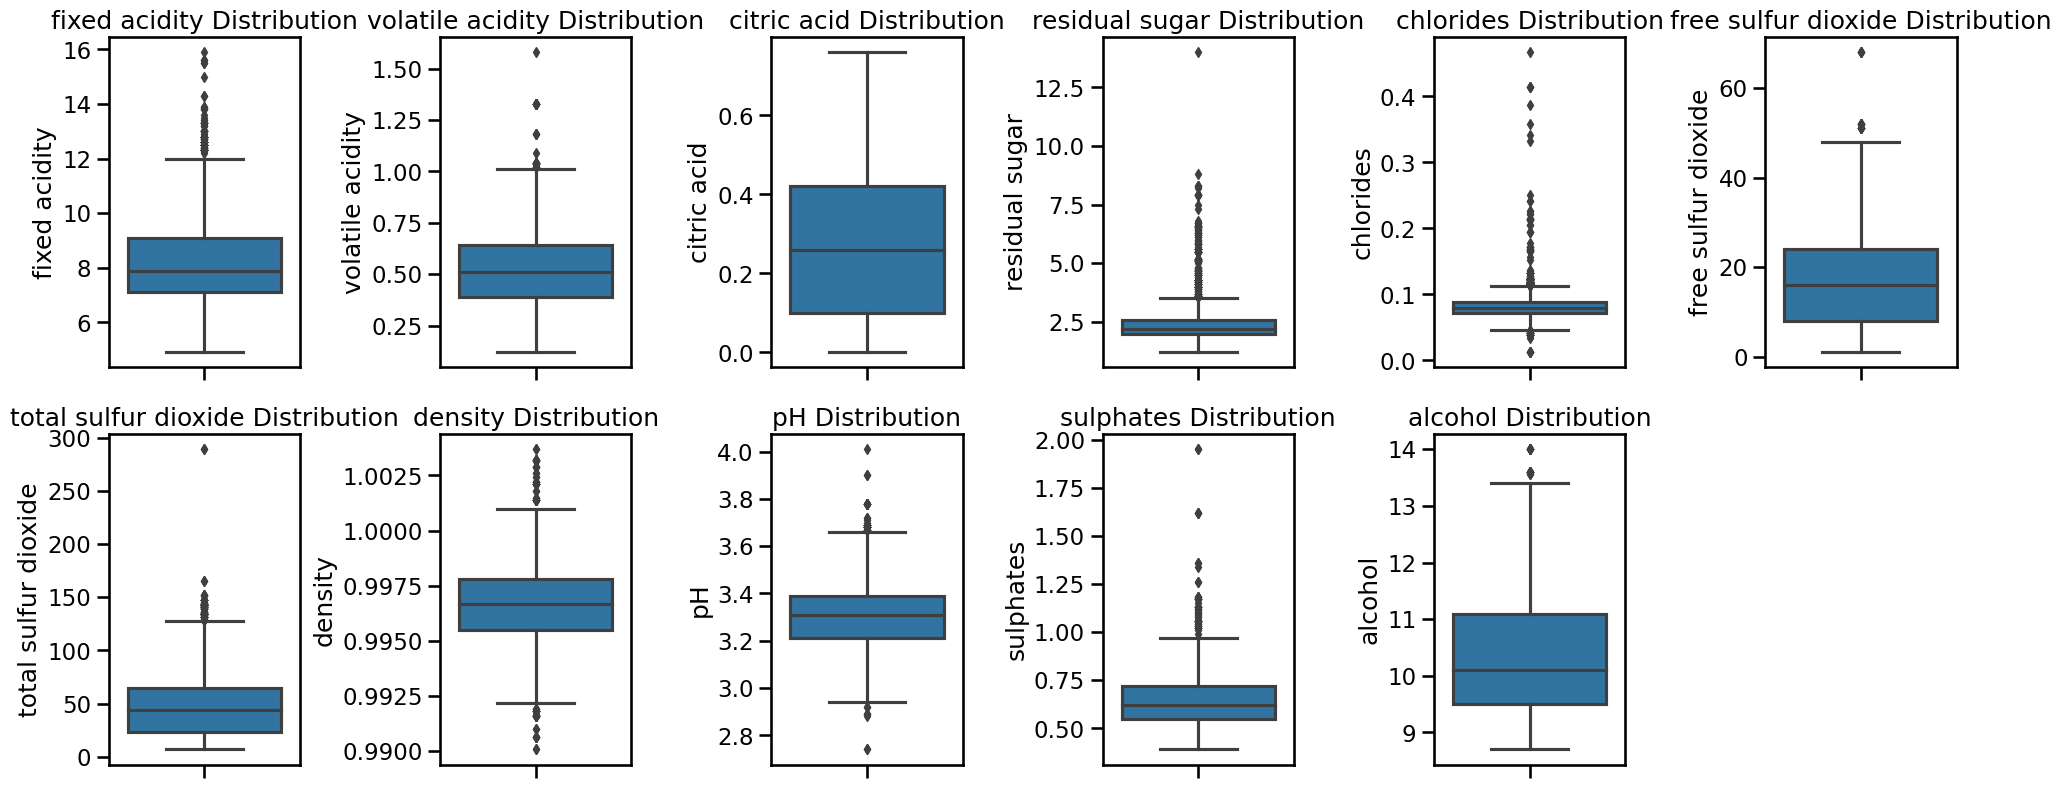

In [15]:
def histograms_plot(dataframe, features, rows, cols): 
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        sns.boxplot(y=dataframe[feature])
        ax.set_title(feature+" Distribution",color='black')
    fig.tight_layout()  
    plt.show()

histograms_plot(df,num_cols,5,6)

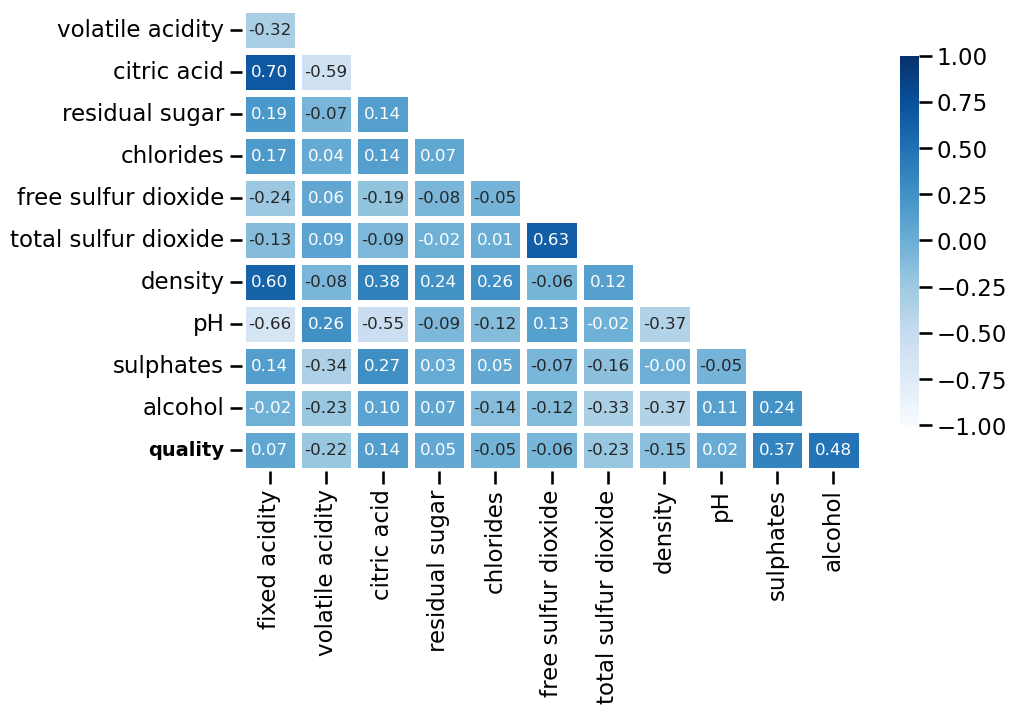

In [16]:
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(10, 6))
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
sns.heatmap(corr, mask=mask, fmt=".2f", cmap='Blues',vmin=-1, vmax=1, annot=True, annot_kws={'fontsize': 12}, cbar_kws={"shrink": .8}, linewidths=5,)
plt.yticks(rotation=0)
plt.yticks()[-1][-1].set_fontsize(14)
plt.yticks()[-1][-1].set_fontweight('bold')
plt.show()

# Model

In [17]:
rbs = RobustScaler()

y = df['quality']
x = df.drop(columns='quality',axis=1)
x[x.columns] = rbs.fit_transform(x[x.columns])

df_train = x.iloc[:-len(test),:]
df_train['Class'] = y[:-len(test)]

df_test = df.iloc[-len(test):,:].reset_index(drop=True)

x = df_train.drop(['Class'], axis=1)
y = df_train.Class

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, stratify=y, random_state=2023)

# CatBoos Classifier

In [18]:
cat = CatBoostClassifier(verbose=False)
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_test)
print(round(acc(y_test,cat_pred),4))

0.5655


# LGBMClassifier

In [19]:
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
lgb_pred = cat.predict(X_test)
print(round(acc(y_test,lgb_pred),4))

0.5655


# XGBRegressor

In [20]:
cat_reg = XGBRegressor()
cat_reg.fit(X_train, y_train)
cat_reg_pred = cat.predict(X_test)
print(round(acc(y_test,cat_reg_pred),4))

0.5655


# XGBRegressor

In [55]:
from sklearn.preprocessing import LabelEncoder

In [56]:
lbl = LabelEncoder()
y_train1 = lbl.fit_transform(y_train)
lgb_reg = XGBClassifier()
lgb_reg.fit(X_train, y_train1)
lgb_reg_pred = cat.predict(X_test)
print(round(acc(y_test,lgb_reg_pred),4))

0.5655


# CatBoostRegressor

In [22]:
lgb_reg = CatBoostRegressor(verbose=False)
lgb_reg.fit(X_train, y_train)
lgb_reg_pred = cat.predict(X_test)
print(round(acc(y_test,lgb_reg_pred),4))

0.5655


In [23]:
sub['quality'] = cat.predict(df_test)
sub['quality'] = sub['quality'].astype(int)
sub.to_csv('submission_1.csv',index=False)

In [49]:
from sklearn.model_selection import StratifiedKFold
from statistics import mean

x = train.iloc[:,:-1]
y = train.iloc[:,-1]

x_scaled = rbs.fit_transform(x[x.columns])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lt_acc = []

for train_index, test_index in skf.split(x, y):
	x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
	y_train_fold, y_test_fold = y[train_index], y[test_index]
	lgb.fit(x_train_fold, y_train_fold)
	lt_acc.append(lgb.score(x_test_fold, y_test_fold))

print(mean(lt_acc))	

0.5656760596732181
